# Matchup Analysis & Correlation Matrix

Focuses on the interactions between fighters. We move beyond individual stats to analyze matchup dynamics. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load Datasets
fights = pd.read_csv('../data/processed/ufc_fight_stats_cleaned.csv')
profiles = pd.read_csv('../data/processed/ufc_modeling_data_final.csv')
fighters_raw = pd.read_csv('../data/external/fighters.csv') # For Height/Reach

print(f"Loaded {len(fights)} fights and {len(profiles)} profiles.")


Loaded 16964 fights and 1775 profiles.


## 1. Feature Engineering: Physical Stats

In [8]:
def parse_height(h):
    try:
        if pd.isna(h): return np.nan
        s = str(h).replace('"', '').replace("'", '.') # Handle 5'11" format
        if '.' in s:
            parts = s.split('.')
            return int(parts[0])*12 + int(parts[1])
        return float(h)
    except: return np.nan

fighters_raw['Height_Inches'] = fighters_raw['Ht.'].apply(parse_height)
fighters_raw['Reach_Inches'] = fighters_raw['Reach'] # Assuming already numeric or cleanable

# Create a physical stats lookup
physical_stats = fighters_raw[['Fighter_Id', 'Full Name', 'Height_Inches', 'Reach_Inches']].copy()
# Try merging on Name first
physical_stats = physical_stats.rename(columns={'Full Name': 'Fighter'})


## 2. Creating the Matchup Dataset
Merge Fighter A and Fighter B stats into each fight row.

In [9]:
# 1. Merge Styles (Fighter A)
df = fights.merge(profiles, on='Fighter', how='inner')
# 2. Merge Styles (Fighter B - Opponent)
df = df.merge(profiles, left_on='Opponent', right_on='Fighter', how='inner', suffixes=('', '_Opp'))

# 3. Merge Physicals (Fighter A)
df = df.merge(physical_stats[['Fighter', 'Height_Inches', 'Reach_Inches']], on='Fighter', how='left')
# 4. Merge Physicals (Fighter B)
df = df.merge(physical_stats[['Fighter', 'Height_Inches', 'Reach_Inches']], left_on='Opponent', right_on='Fighter', how='left', suffixes=('', '_Opp'))

# Cleanup
df = df.drop(columns=['Fighter_Opp', 'Fighter_Opp'])
print(f"Matchup Dataset Shape: {df.shape}")

Matchup Dataset Shape: (14492, 59)


## 3. Calculating Advantages (Deltas)
Calculate `Fighter A - Fighter B`. 
* Positive value = Fighter A has the advantage (or higher stat).
* Negative value = Opponent has the advantage.

In [10]:
# Physical Deltas
df['Delta_Height'] = df['Height_Inches'] - df['Height_Inches_Opp']
df['Delta_Reach'] = df['Reach_Inches'] - df['Reach_Inches_Opp']

# Style Deltas (Z-Scores)
df['Delta_Strike_Vol'] = df['Sig_Str_PM_Z'] - df['Sig_Str_PM_Z_Opp']
df['Delta_Grapple_Vol'] = df['Takedown_Att_PM_Z'] - df['Takedown_Att_PM_Z_Opp']
df['Delta_Sub_Threat'] = df['Sub_Att_PM_Z'] - df['Sub_Att_PM_Z_Opp']

# Style Clash (Absolute Difference = How different are they?)
df['Style_Clash_Strike'] = abs(df['Delta_Strike_Vol'])
df['Style_Clash_Grapple'] = abs(df['Delta_Grapple_Vol'])
df['Total_Style_Clash'] = df['Style_Clash_Strike'] + df['Style_Clash_Grapple']

# Outcome Variables
df['Win_Binary'] = df['Won'].astype(int) # 1 if Fighter A won, 0 if lost
df['Is_Finish'] = df['Method'].apply(lambda x: 1 if 'KO' in str(x) or 'SUB' in str(x) else 0)

## 4. Correlation Matrix: Identifying Win Conditions
We correlate the **Deltas** (Advantages) with the **Result** (Win_Binary).

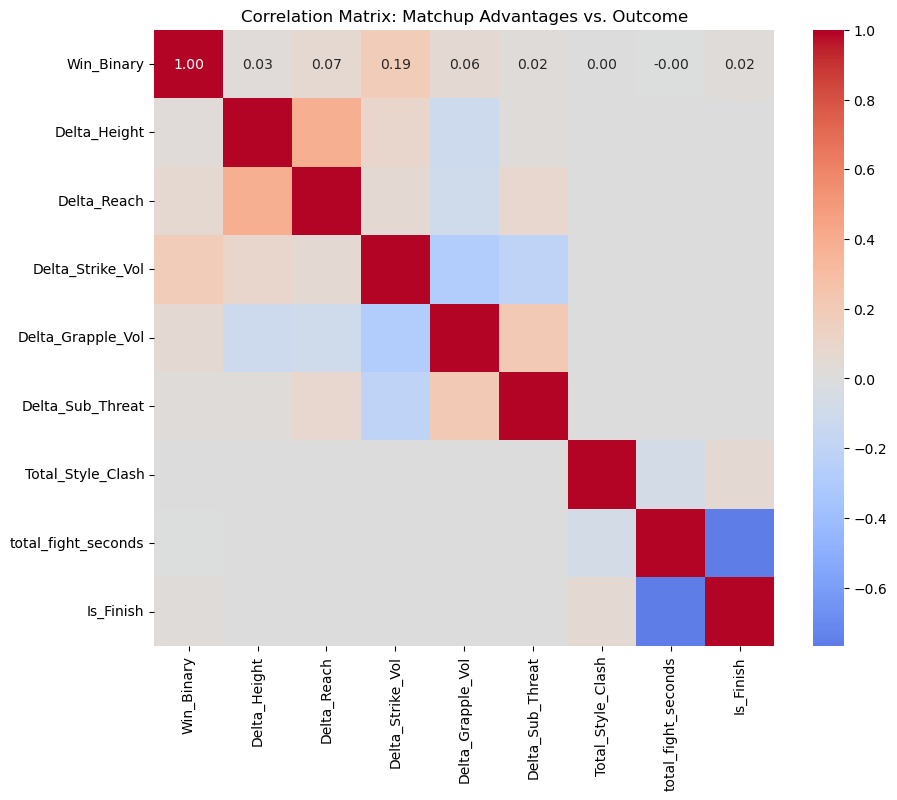

In [11]:
corr_cols = [
    'Win_Binary', 
    'Delta_Height', 'Delta_Reach', 
    'Delta_Strike_Vol', 'Delta_Grapple_Vol', 'Delta_Sub_Threat',
    'Total_Style_Clash', 'total_fight_seconds', 'Is_Finish'
]

corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix: Matchup Advantages vs. Outcome')
plt.show()


## 5. Win Probability Curves

Looking at non-linear relationships.

/var/folders/sk/j1374_rn5qx4kt2s8nz2ykk40000gn/T/ipykernel_21513/3711911719.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_reach = df.groupby('Reach_Bin')['Win_Binary'].mean()


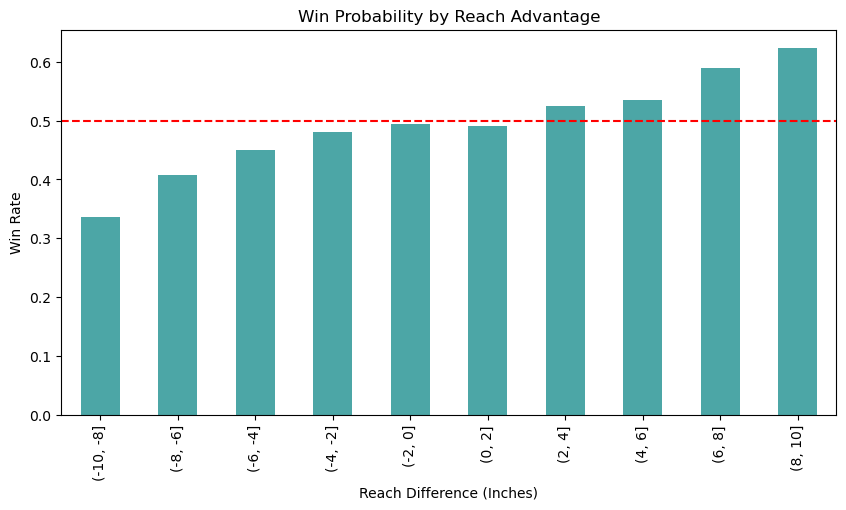

/var/folders/sk/j1374_rn5qx4kt2s8nz2ykk40000gn/T/ipykernel_21513/3711911719.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_vol = df.groupby('Strike_Vol_Bin')['Win_Binary'].mean()


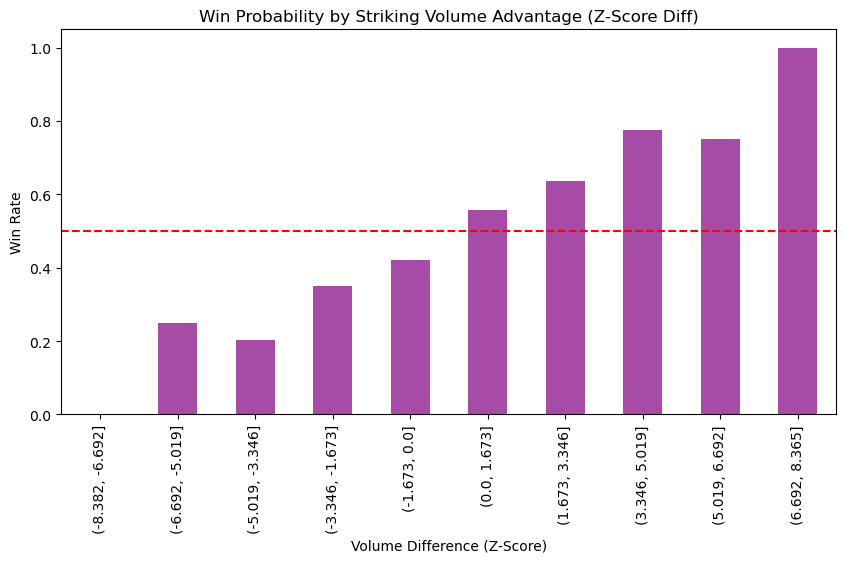

In [12]:
# Binning Reach Advantage
df['Reach_Bin'] = pd.cut(df['Delta_Reach'], bins=range(-10, 11, 2))
win_rate_by_reach = df.groupby('Reach_Bin')['Win_Binary'].mean()

plt.figure(figsize=(10, 5))
win_rate_by_reach.plot(kind='bar', color='teal', alpha=0.7)
plt.title('Win Probability by Reach Advantage')
plt.xlabel('Reach Difference (Inches)')
plt.ylabel('Win Rate')
plt.axhline(0.5, color='red', linestyle='--')
plt.show()

# Binning Strike Volume Advantage
df['Strike_Vol_Bin'] = pd.cut(df['Delta_Strike_Vol'], bins=10)
win_rate_by_vol = df.groupby('Strike_Vol_Bin')['Win_Binary'].mean()

plt.figure(figsize=(10, 5))
win_rate_by_vol.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Win Probability by Striking Volume Advantage (Z-Score Diff)')
plt.xlabel('Volume Difference (Z-Score)')
plt.ylabel('Win Rate')
plt.axhline(0.5, color='red', linestyle='--')
plt.show()


## 6. Style Divergence vs. Finish Rate
Does a "Style Clash" (e.g. High Abs Diff) lead to more Finishes?

/var/folders/sk/j1374_rn5qx4kt2s8nz2ykk40000gn/T/ipykernel_21513/4075123463.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  finish_rate = df.groupby('Clash_Bin')['Is_Finish'].mean()


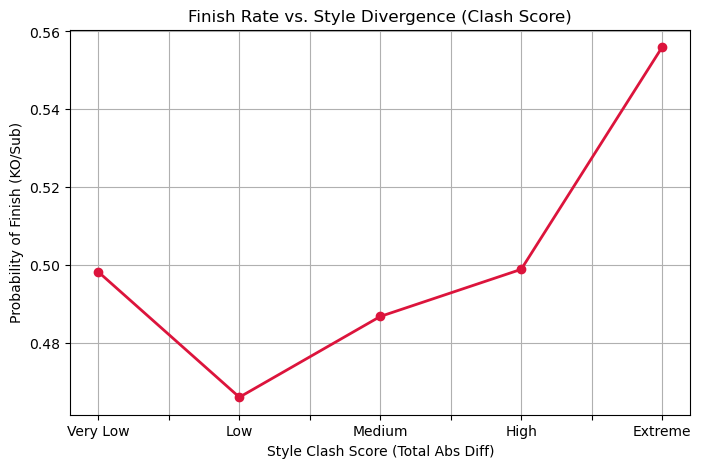

In [13]:
df['Clash_Bin'] = pd.qcut(df['Total_Style_Clash'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Extreme'])
finish_rate = df.groupby('Clash_Bin')['Is_Finish'].mean()

plt.figure(figsize=(8, 5))
finish_rate.plot(kind='line', marker='o', color='crimson', linewidth=2)
plt.title('Finish Rate vs. Style Divergence (Clash Score)')
plt.ylabel('Probability of Finish (KO/Sub)')
plt.xlabel('Style Clash Score (Total Abs Diff)')
plt.grid(True)
plt.show()
